# <div style = 'background-color:#50474E'> <center><font color='#F2DD6C'>Analisis EDA de patrones de facturación apocrifas en ARCA</div><div style = 'background-color:#50474E'> <center>.<font color='#50474E'></div>

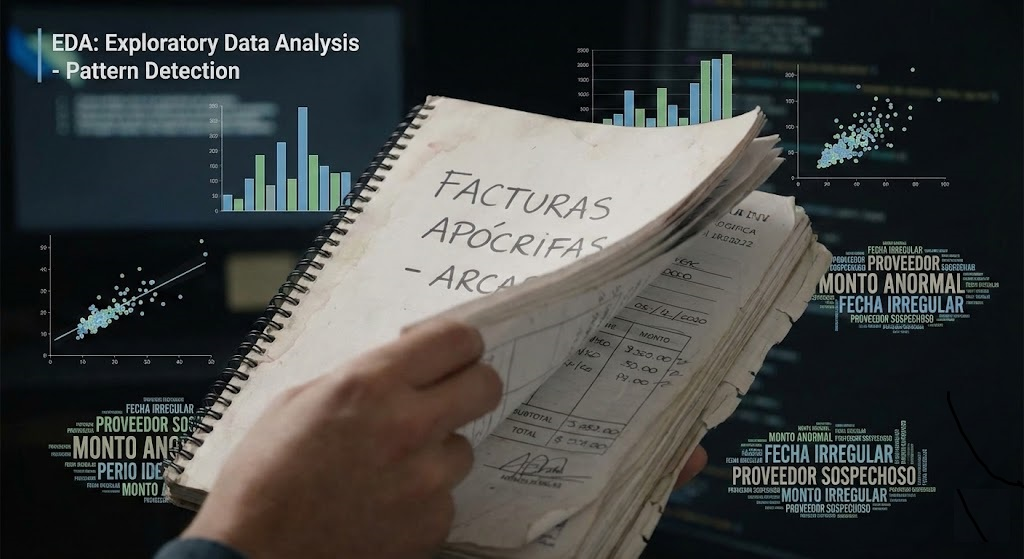

Las herramientas de fiscalización vinculadas a facturas apócrifas y registros asociados (como la Base APOC o “Base de Contribuyentes No Confiables”) se remontan a normativas internas de AFIP de los años ’90 y 2000, como la Instrucción General 326/1997 y posteriores (IG 748/05 y otras que evolucionaron ese registro).

Estas bases se usaban para identificar sujetos y documentos que presentaban irregularidades objetivas, como proveedores que simulaban operaciones o emitían facturas sin actividad económica real.

Dentro de este esquema de control, el CUIT funciona como el identificador principal de los contribuyentes, permitiendo distinguir y analizar a los sujetos fiscales de acuerdo con su naturaleza jurídica. El CUIT se encuentra conformado por 11 dígitos, distribuidos en tres partes:

$$ XX - XXXXXXXXX - X $$

---
1 - **Primeros 2 dígitos** (Indican qué tipo de persona o entidad es).

A-Personas humanas

20 → varón

27 → mujer

23 → asignación especial (cuando hay conflictos con DNI, duplicaciones, etc.)


B- Personas jurídicas

30 → sociedades comerciales (SA, SRL, SAS, etc.)

33 → asociaciones, fundaciones, cooperativas

34 → entidades del exterior / organismos especiales

---
2 - **Bloque central** (8 dígitos)

En personas humanas: el DNI (con ceros a la izquierda si hace falta)

En personas jurídicas: número interno asignado por AFIP/ARCA

---
3 - **Último dígito** (dígito verificador)

Se calcula con un algoritmo módulo 11 (método matemático clásico de control). Sirve para validar que el CUIT esté bien formado, si alguien se equivoca al tipear un número, el dígito verificador no coincide y el CUIT se invalida.

A partir de este identificador fiscal, se construye la base de análisis utilizada en este trabajo, la cual proviene de información de acceso público provista por AFIP/ARCA. Dicha base contiene únicamente cuatro campos: el campo “CUIT”, que identifica al contribuyente incorporado en el listado; “Fecha Condición Apócrifo”, que indica el momento en que se detecta la emisión de comprobantes no genuinos; “Fecha de Publicación”, que señala la fecha a partir de la cual el sujeto es publicado como no confiable; y un campo “Descripción”, sin información relevante para el análisis.

En el análisis se optó por enmascarar los números de CUIT y no publicar la base de datos, por razones de confidencialidad y protección de los datos.

#### Indice

<div class="alert alert-block alert-info" style="margin-top: 20px">

1.  [Preparación y limpieza de los datos](#0)<br>
2.  [Analisis exploratorio de los datos](#1)<br>
3.  [Concluciones](#3) <br>

</div>

## <div style = 'background-color:#50474E'> <center><font color='white'>① Preparación y limpieza de los datos </font></div> <a id="0"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore") # Filtrar avisos

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(
    'FacturasApocrifas.txt', 
    sep=',',               # Especifico que la coma es el separador de las columnas.
    decimal='.',           # Si los decimales vienen con punto o coma (ej: decimal=',')
    index_col=False        # Por si el txt tiene una coma de más al final de cada línea como es este caso.
)

In [3]:
# Aplico una mascara para proteger datos sensibles.

df["CUIT"] = df["CUIT"].astype(str)

df["CUIT"] = (
    df["CUIT"]
    .astype(str)
    .str.replace(r"(\d{2})\d{7}(\d{1})", r"\1*******\2", regex=True)
)

In [4]:
df.sample(5)

,CUIT,Fecha Condicion Apocrifo,Fecha Publicacion,Descripcion \t
5978,20*******76,01/11/2023,30/08/2025,NaN
13000,30*******20,01/08/2011,27/04/2018,NaN
5079,20*******04,04/12/2019,05/02/2021,NaN
18074,30*******14,01/01/2019,12/12/2023,NaN
1777,20*******83,24/09/2010,10/12/2019,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43983 entries, 0 to 43982
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   CUIT                       43983 non-null  object
 1    Fecha Condicion Apocrifo  43983 non-null  object
 2    Fecha Publicacion         43983 non-null  object
 3    Descripcion 	             1 non-null      object
dtypes: object(4)
memory usage: 1.3+ MB


In [6]:
df.columns = ['CUIT', 'Fecha_Apoc', 'Fecha_Public', 'Descripcion'] # Cambio nombre de columnas.

In [7]:
df=df.drop("Descripcion", axis=1) # Borro esta columna que no tiene ningun valor.

In [8]:
df['Fecha_Apoc'] = pd.to_datetime(df['Fecha_Apoc'], dayfirst=True) # Dayfirst hace que se cuente el dia primero como se usa en Argentina.
df['Fecha_Public'] = pd.to_datetime(df['Fecha_Public'], dayfirst=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43983 entries, 0 to 43982
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CUIT          43983 non-null  object        
 1   Fecha_Apoc    43983 non-null  datetime64[ns]
 2   Fecha_Public  43983 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 1.0+ MB


In [10]:
df['Demora_Deteccion'] = (df['Fecha_Public'] - df['Fecha_Apoc']).dt.days

El nuevo campo creado, "Demora_Deteccion" indica cuánto tiempo pasó desde que se detectó la irregularidad hasta que se hizo pública. Un delta muy alto podría indicar CUITs que operaron "en las sombras" mucho tiempo.

In [11]:
df['Fecha_ts'] = df['Fecha_Apoc'].astype('int64') // 1e9 # Convierte a int64 dando la cantidad de nanosegundos desde 01/01/1970 luego divide por 1e9 para dejarlo en segundos.

In [12]:
df['FechaPub_ts'] = df['Fecha_Public'].astype('int64') // 1e9 # Convierte a int64 dando la cantidad de nanosegundos desde 01/01/1970 luego divide por 1e9 para dejarlo en segundos.

In [13]:
df

,CUIT,Fecha_Apoc,Fecha_Public,Demora_Deteccion,Fecha_ts,FechaPub_ts
0,30*******83,2005-11-08,2005-11-08,0,1.131408e+09,1.131408e+09
1,24*******93,2004-04-28,2004-04-28,0,1.083110e+09,1.083110e+09
2,20*******54,2000-03-31,2000-03-31,0,9.544608e+08,9.544608e+08
3,30*******60,2000-10-27,2000-10-27,0,9.726048e+08,9.726048e+08
4,30*******56,1999-09-21,1999-09-21,0,9.378720e+08,9.378720e+08
...,...,...,...,...,...,...
43978,30*******88,2024-10-11,2025-08-04,297,1.728605e+09,1.754266e+09
43979,20*******19,2024-12-28,2025-08-19,234,1.735344e+09,1.755562e+09
43980,20*******07,2024-08-21,2025-09-10,385,1.724198e+09,1.757462e+09
43981,27*******77,2024-04-04,2025-09-30,544,1.712189e+09,1.759190e+09


In [14]:
df = df[
    (df['Fecha_Apoc'] >= '2000-01-01') &
    (df['Fecha_Public'] >= '2000-01-01')
]
df['Fecha_Apoc'] >= '2000-01-01'

# Filtrar datos desde el 01/01/2000

0        True
1        True
2        True
3        True
5        True
         ... 
43978    True
43979    True
43980    True
43981    True
43982    True
Name: Fecha_Apoc, Length: 41216, dtype: bool

## <div style = 'background-color:black'> <center><font color='white'>② Analisis exploratorio de los datos (EDA) </font></div><a id="1"></a>

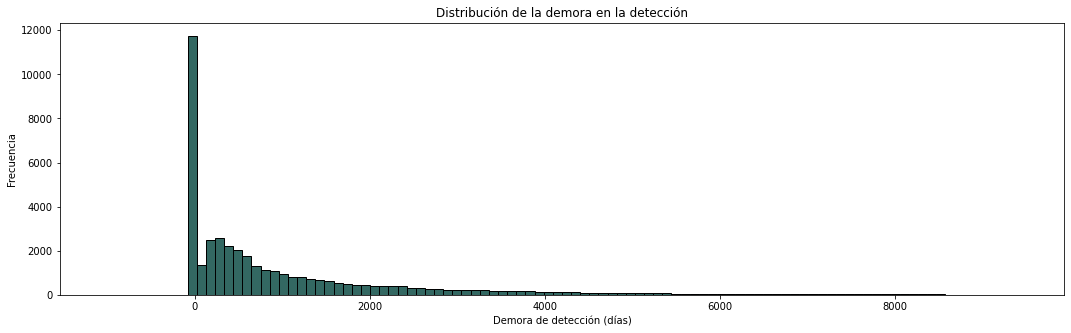

In [47]:
plt.figure(figsize=(18, 5))
df['Demora_Deteccion'].hist(
    bins=100,
    color='#336862',
    edgecolor='black'
)
plt.grid(False)
plt.xlabel('Demora de detección (días)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la demora en la detección')
plt.show()

Este grafico muestra la distribución de la demora en la detección de facturas apocrifas, viene a ser en forma grafica una medición de la velocidad de respuesta de ARCA ante este problema. El gran pico inicial evidencia una detección inmediata (cerca del valor 0). Significa que existe un volumen masivo de facturas que son detectadas casi de forma instantánea o en un plazo de muy pocos días. Esto sugiere que los sistemas informáticos de ARCA tienen controles sistémicos automáticos entonces muchas facturas "mueren" al nacer porque el emisor ya está en una lista de riesgo, no tiene capacidad económica o el CUIT está bloqueado.

Luego tiene una larga cola que se extiende largamente hacia la derecha del eje X. Significa que si una factura apócrifa logra superar los primeros filtros automáticos, pueden pasar cientos de días antes de ser detectada. Esto es un riesgo operativo puesto que son las facturas más peligrosas para el fisco ya que permiten que el crédito fiscal sea utilizado por el receptor antes de que la usina de facturas sea desmantelada.

Entonces en resumen la mayoría se detecta rápido (moda y mediana bajas) y los casos complejos son pocos en comparación al total pero tardan mucho en salir a la luz.

<AxesSubplot:>

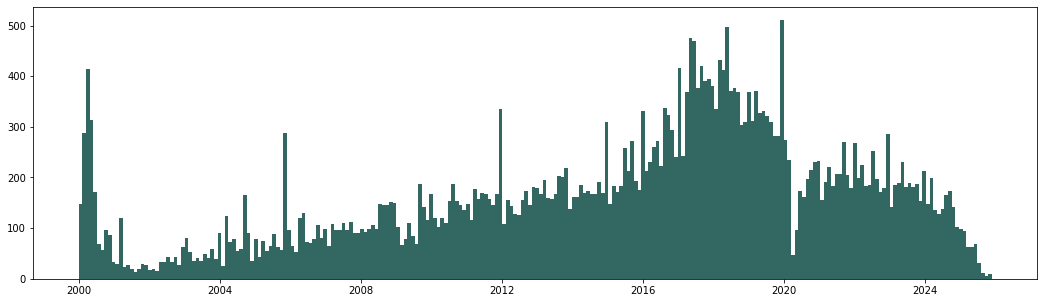

In [16]:
df['Fecha_Apoc'].hist(bins=250, grid=False, color='#336862', figsize=(18, 5))

Analizando el campo "Fecha_Apoc", existe un pico a la izquierda durante los primeros años del grafico, esto muestra un evento o período inicial con un alto volumen de detecciones que podria coincidir con la implementación de nuevas bases de datos o cruces sistémicos que barrieron con las irregularidades acumuladas durante años.

A partir de ese pico, se observa un incremento paulatino en la frecuencia de detección a medida que se avanza hacia la derecha del eje X. Esto suele indicar una mayor sofisticación de los algoritmos de fiscalización (uso de Big Data y modelos de riesgo) que detectan más casos por unidad de tiempo.

Posterior al 2016 y antes del 2020, se puede ver una zona de mayor actividad, donde la fiscalización electrónica se volvió mas masiva, detectando una gran cantidad de "usinas" de facturas en un lapso corto.

Durante 2020 se observa una caida de la frecuencia muy pronunciada. Existen tres razones fundamentales ligadas al contexto Argentino:

A-Parálisis Administrativa y Judicial (ASPO)
Debido a la pandemia de COVID-19, las áreas operativas de la entonces AFIP estuvo bajo regímenes de presencialidad mínima o trabajo remoto limitado. Muchos procesos de inspección física y fiscalizaciones presenciales que validan las sospechas de los sistemas automáticos se detuvieron o ralentizaron considerablemente.

B-Suspensión de Plazos y Feria Fiscal
Durante gran parte de 2020 se dictaron sucesivas ferias fiscales extraordinarias. Esto significó la suspensión del cómputo de los plazos procesales.

C-Caída de la Actividad Económica
Con el cierre de comercios y la caída drástica del consumo durante la cuarentena estricta, el mercado de facturas apócrifas también experimentó un enfriamiento temporal: hubo menos facturas emitidas en general, y por ende menos detecciones registradas en ese período.

Entonces el grafico refleja que la lucha contra la facturación apócrifa no es lineal si no que depende de la capacidad operativa del organismo y del contexto macroeconómico. La caida en detecciones en el 2020 es una anomalía externa (pandemia) y no necesariamente una mejora en el cumplimiento voluntario de los contribuyentes.

<AxesSubplot:>

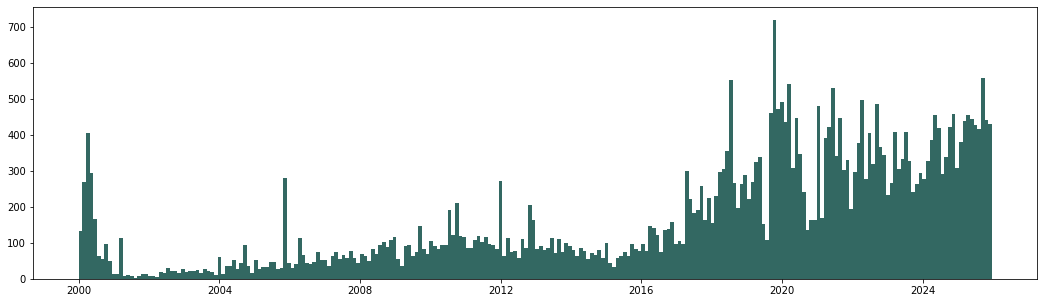

In [17]:
df['Fecha_Public'].hist(bins=250, grid=False, color='#336862', figsize=(18, 5))

Ahora analizando el campo "Fecha_Public", el gráfico presenta la distribución histórica de las fechas de publicación de CUITs vinculados a facturación apócrifa, revelando una evolución dividida en tres etapas críticas:

1. Fase de Irrupción y Estabilización (Periodo Inicial)
Se observa un pico atípico inicial que coincide morfológicamente con el gráfico de "Fecha de Detección". Este comportamiento sugiere un evento de regularización masiva o una campaña de fiscalización puntual que sacó a la luz un stock acumulado. Tras este impulso el histograma entra en una fase de valle, caracterizada por una frecuencia mínima y baja volatilidad, lo que indica un periodo de aparente calma o de operaciones marginales.

2. Punto de Inflexión y Crecimiento Exponencial (Post-2016)
A partir del año 2016, la tendencia cambia drásticamente. El gráfico muestra un crecimiento sostenido y exponencial en la aparición de nuevos CUITs publicados. Este fenómeno podría estar vinculado a una mayor capacidad de procesamiento de datos por parte de los organismos de control, lo que permitió identificar y publicar irregularidades a un ritmo mucho más acelerado que en la década anterior.

3. Fase Actual: Volatilidad Extrema y Saturación
El tramo final del histograma se caracteriza por una inestabilidad aguda y picos de frecuencia que superan significativamente a los del periodo inicial. Esta volatilidad extrema sugiere:

a) Una fragmentación de las maniobras (más actores emitiendo facturas apócrifas).
b) Una respuesta institucional más agresiva que publica lotes de CUITs de forma intermitente pero masiva.
c) Un escenario donde la cantidad de casos detectados ha alcanzado máximos históricos, reflejando una problemática técnica y administrativa de gran escala.

Mientras que los primeros años muestran un comportamiento controlado, el periodo post-2016 transforma el panorama en uno de riesgo sistémico. La magnitud de los picos finales indica que la publicación de CUITs apócrifos no solo ha aumentado en volumen, sino que se ha vuelto mucho más errática, dificultando la predictibilidad del fraude fiscal.

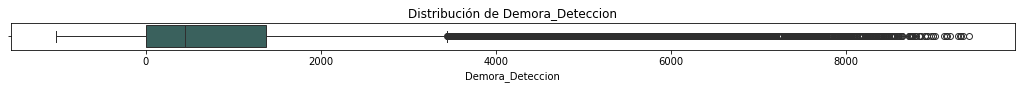

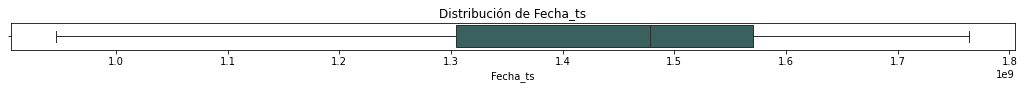

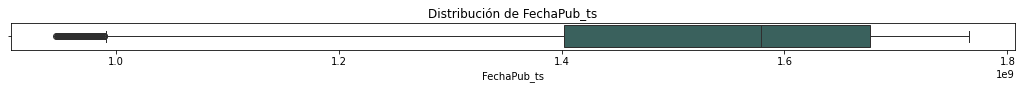

In [18]:
for col in ['Demora_Deteccion', 'Fecha_ts', 'FechaPub_ts']:
    plt.figure(figsize=(18, 0.5))
    sns.boxplot(x=df[col], color='#336862')
    plt.title(f"Distribución de {col}")
    plt.show()

La primer caja sobre la "Distribución de Demora_Deteccion", se observa un sesgo extremo a la derecha, la mediana está muy cerca del cero, lo que indica que una buena parte de los casos se detecta en un tiempo razonable. Sin embargo la larguísima cola de outliers (puntos negros) a la derecha es una señal de alarma. Existen outliers donde la demora supera los 8000 dias (mas de 20 años, lo que puede ser por un error estadistico, una migración de sistemas, una limpieza de archivo o que simplemente se tardo eso aunque parece improbable, lo más probable es que sea una combinación de un pequeño porcentaje de errores de sistema y un volumen de casos históricos que el organismo sacó del cajón y publicó masivamente en años recientes para regularizar el padrón).

Caja sobre "Distribución de Fecha_ts" (Momento del Fraude) la caja esta desplazada a la derecha, la mediana se ubica cerca de 1.5  (aproximadamente seria en el año 2017). Esto determina que el 50% central de la actividad fraudulenta es relativamente reciente. Tambien destacar que el bigote izquierdo es largo lo que indica que todavía se están procesando o detectando facturas de periodos muy antiguos.

Caja sobre "Distribución de FechaPub_ts" (Momento de Publicación), la caja en cuestion luce un poco más compacta y está mucho más desplazada hacia la derecha que la de Fecha_ts. Esto indica que la mayoría de las publicaciones en el listado de apócrifos ocurrieron en un periodo de tiempo más reciente y acotado. Hay precencia de outliers a la izquierda los cuales representarian publicaciones aisladas de CUITs muy antiguos.

Al comparar las dos ultimas cajas, se observa que la mediana de la fecha de publicación está ubicada más a la derecha que la mediana de la fecha del evento apócrifo. Esta diferencia representa la demora estructural del organismo para completar la tarea.

<AxesSubplot:title={'center':'Top 50 CUITs más Reincidentes'}, xlabel='CUIT'>

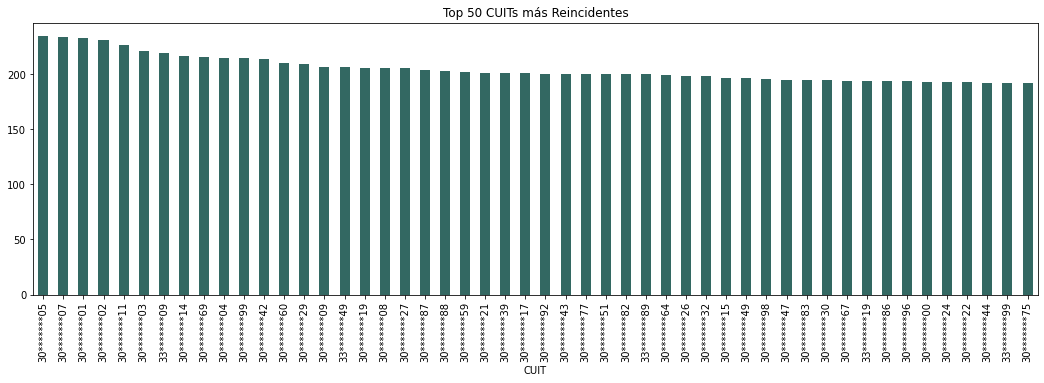

In [19]:
df["CUIT"].value_counts().head(50).plot(kind='bar', title='Top 50 CUITs más Reincidentes', figsize=(18, 5), color='#336862')

En este gráfico se presenta el top 50 de CUITs con mayor cantidad de detecciones de comprobantes apócrifos. Se trata de los contribuyentes con mayor nivel de recurrencia en este tipo de irregularidades, por lo que resultan prioritarios para su análisis y abordaje. En este caso este top 50 esta compuesto por personas juridicas y de asociaciones o fundaciones.

#### Agregando mas caracteristicas:

Otra caracteristica para agregar es permitirse preguntar a los datos, ¿Es una publicación reciente o es un CUIT manchado/quemado hace años? Puesto que los CUITs recién publicados son más relevantes para análisis de riesgo actual.
$$Hoy - Fecha\_Public$$

In [20]:
hoy = pd.Timestamp.today() # Lectura del hoy dia
df['Alerta_Vieja'] = (hoy - df['Fecha_Public']).dt.days > 365 # Si cumple la condicion sera TRUE, por el contrario mostrara FALSE.

In [21]:
df['CUIT_Prefijo'] = df['CUIT'].astype(str).str[:2] # Mostrar los 2 primeros valores del CUIT (explicado mas arriba para quien se usa cada prefijo).

In [22]:
df.sample()

,CUIT,Fecha_Apoc,Fecha_Public,Demora_Deteccion,Fecha_ts,FechaPub_ts,Alerta_Vieja,CUIT_Prefijo
18505,33*******69,2019-04-26,2019-10-31,188,1.556237e+09,1.572480e+09,True,33


<AxesSubplot:title={'center':'Frecuencia de Alertas Antiguas (True) vs Actuales (False)'}, ylabel='Alerta_Vieja'>

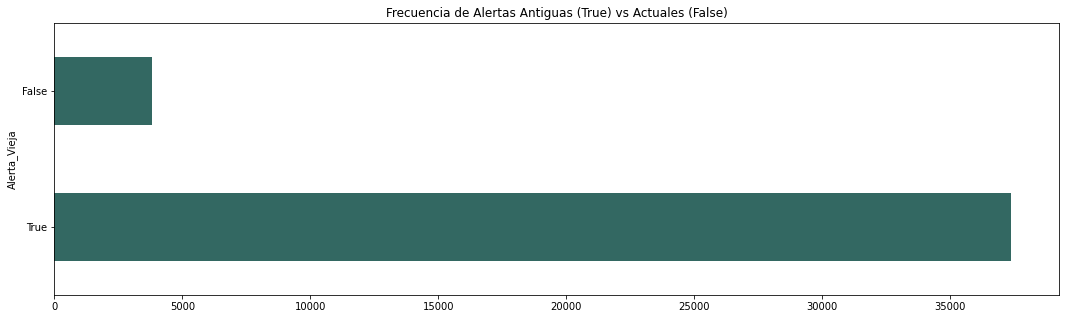

In [33]:
df["Alerta_Vieja"].value_counts().plot(kind='barh', title='Frecuencia de Alertas Antiguas (True) vs Actuales (False)', figsize=(18, 5), color='#336862')

In [23]:
df["CUIT_Prefijo"].value_counts()

CUIT_Prefijo
30    19159
20    13960
27     4313
33     1911
23     1756
24      116
34        1
Name: count, dtype: int64

In [35]:
mapa_prefijos = {
    20: "Persona humana (varón)",
    27: "Persona humana (mujer)",
    23: "Persona humana (casos especiales)",
    24: "Persona humana (casos especiales)",
    30: "Persona jurídica (empresa)",
    33: "Entidad especial",
    34: "Entidad especial"
}

df["CUIT_Prefijo"] = df["CUIT_Prefijo"].astype(int)
df["CUIT_Descripcion"] = df["CUIT_Prefijo"].map(mapa_prefijos)

In [38]:
df[["CUIT_Prefijo", "CUIT_Descripcion"]].value_counts()

CUIT_Prefijo  CUIT_Descripcion                 
30            Persona jurídica (empresa)           19159
20            Persona humana (varón)               13960
27            Persona humana (mujer)                4313
33            Entidad especial                      1911
23            Persona humana (casos especiales)     1756
24            Persona humana (casos especiales)      116
34            Entidad especial                         1
Name: count, dtype: int64

<AxesSubplot:title={'center':'Frecuencia de Alertas Antiguas (True) vs Actuales (False)'}, ylabel='CUIT_Descripcion'>

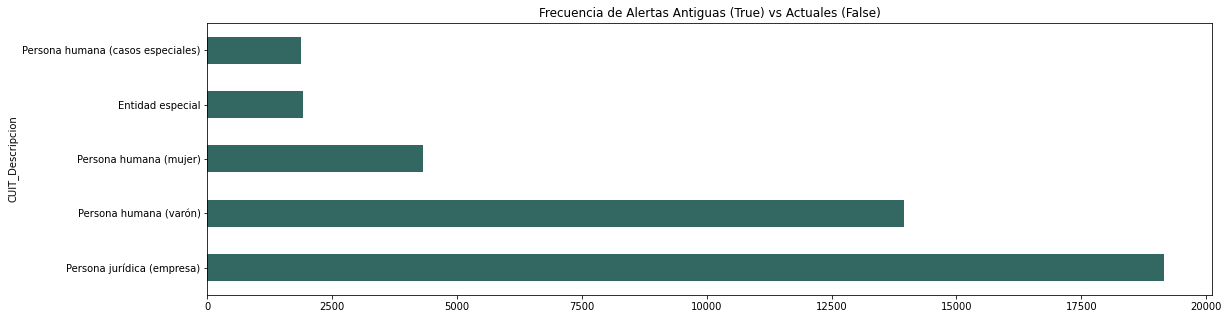

In [41]:
df["CUIT_Descripcion"].value_counts().plot(kind='barh', title='Frecuencia de Alertas Antiguas (True) vs Actuales (False)', figsize=(18, 5), color='#336862')

Al analizar el tipo de CUIT al que pertenecen y su mayor frecuencia en la emisión de facturas apócrifas, se observa que el fraude masivo no responde a conductas individuales, sino a estructuras corporativas. El uso de sociedades permite licuar la responsabilidad penal y civil o al menos eso se intenta. Además, una empresa puede emitir volúmenes de facturación mucho más altos que un individuo antes de levantar sospechas, lo que explica por qué son el vehículo preferido para este delito, tambien porque detrás de la maniobra fraudulenta el emisor esté oculto tras capas de directorios y prestanombres lo que dificulta su detección y desarticulación, lo que a su vez explica la longevidad de algunos CUITs que generan demoras de detección extremas.

## <div style = 'background-color:black'> <center><font color='white'>③ Conclusiones </font></div><a id="3"></a>

Como conclusión, y en base al análisis de esta base de datos —limitada a tres variables: CUIT, fecha de detección de apócrifo y fecha de publicación—, el hallazgo más relevante desde una perspectiva estratégica es la alta asimetría en la distribución del fenómeno, donde dos categorías concentran casi la totalidad de los casos.

Esta concentración evidencia que la facturación apócrifa no se distribuye de manera homogénea, sino que responde a patrones estructurales bien definidos. En este contexto, una estrategia de fiscalización uniforme resultaría ineficiente, ya que implicaría destinar una proporción significativa de recursos a categorías con una contribución marginal al volumen total del fraude.

En cambio, focalizar los esfuerzos de control en las Personas Jurídicas y, en segundo término, en las Personas Humanas de sexo masculino, permitiría reducir de forma sustancial la facturación apócrifa del sistema, maximizando el impacto de las acciones de fiscalización con un uso más eficiente de los recursos disponibles.

Otro de los resultados que surge del análisis es la mayor presencia de Personas Humanas de sexo masculino como segunda categoría con mayor incidencia. Este comportamiento puede interpretarse a partir del rol histórico en la titularidad de CUITs operativos, dado que, tradicionalmente, los CUITs asociados a actividades comerciales de mayor riesgo o informalidad han estado mayoritariamente a nombre de varones. Esta característica estructural se ve luego reflejada en los datos observados.

---
✍️ Autor: Néstor Díaz — Contador Público | Analista de Datos | Machine Learning

📅 Proyecto: Analisis EDA de patrones de facturación apocrifas en ARCA.

---